<img src="./img/oscon.png" width="400">


# Install Checks 
Make sure you have all the modules we will use throughout the training. 

--

If you haven't already done so, we recommend that you install TensorFlow in a seperate virtualenv (or conda environment). First create a virtualenv (pip install virtualenv, if you don't have it). 

~~~bash
$cd ~
$mkdir envs
$virtualenv ~/envs/tensorflow
~~~

Then activate the virtualenv and install TensorFlow (this will be the basic CPU-enabled version, but that's good enough for now).  

~~~bash
$source ~/envs/tensorflow/bin/activate
(tensorflow)$pip install tensorflow
~~~



In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib
import sklearn

import pandas as pd 
import keras

Using TensorFlow backend.


Take note what version of TensorFlow you are currently using. We assume you are using a version $\geq$ 1.0, some (rather small) adaptation might be necessary if you are using a previous version. 

In [2]:
tf.__version__

'0.12.0-rc0'

# Hello World
We kick off with a simple "Hello World" exmaple. 

In [3]:
h = tf.constant("Hello")
w = tf.constant(" World!")
hw = h + w

with tf.Session() as sess:
    ans = sess.run(hw)

print(ans)

Hello World!


In [4]:
print(h)
print(hw)

Tensor("Const:0", shape=(), dtype=string)
Tensor("add:0", shape=(), dtype=string)


# MNIST
The MNIST (Mixed National Institue of Standards and Technology) handwritten digits dataset is one of the most researched datasets in image processing and machine learning, and has played an important role in the development of artificial neural networks.

Our first example will be a simple softmax-regression model on the raw pixels of the digit images. First, let's take a look at the data!

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
import sys

# This is where the MNIST data will be downloaded to. If you already have it on your 
# machine then set the path accordingly to prevent an extra download. 
DATA_DIR = '/tmp/data' if not 'win' in sys.platform else "c:\\tmp\\data"

# Load data 
data = input_data.read_data_sets(DATA_DIR, one_hot=True)

print("Nubmer of training-set images: {}".format(len(data.train.images)))
print("Luckily, there are also {} matching labels.".format(len(data.train.labels)))

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Nubmer of training-set images: 55000
Luckily, there are also 55000 matching labels.


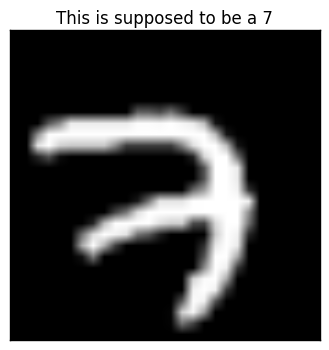

In [6]:
import matplotlib.pyplot as plt 
%matplotlib inline  

first_img = data.train.images[0].reshape(28, 28)
first_lbl = data.train.labels[0].argmax()

plt.figure()
plt.imshow(first_img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("This is supposed to be a {}".format(first_lbl))

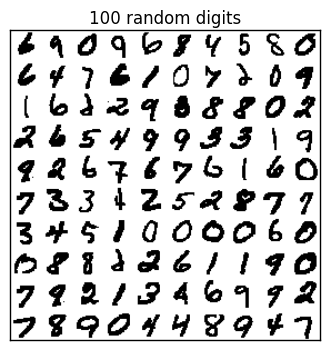

In [7]:
img = np.vstack([np.hstack([img.reshape(28, 28) 
                            for img in data.train.images[np.random.choice(1000, 10)]])
                 for i in range(10)])
img = np.logical_not(img)

plt.figure()
plt.imshow(img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("100 random digits")

# Softmax Regression
Put simply, the softmax regression model will figure out for each pixel in the image, which digits tend to have high (or low) values in that location. For instance, the center of the image will tend to be white for zeros, but black for sixes. Thus, a black pixel in the center of an image will be evidence against the image containing a zero, and in favor of it containing a six.

Learning in this model consists of finding weights that tell us how to accumulate evidence for the existence of each of the digits. With softmax regression, we will not use the spatial information in the pixel layout in the image.

$ evidence(i) = \langle x, w^i \rangle $ 



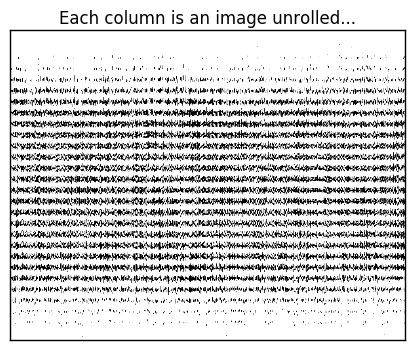

In [22]:
# Get the raw (vector) image and labael -- see what it looks like when not a rectangle
img = data.train.images[:1000]

# Plot 
plt.figure()
plt.imshow(np.logical_not(img).T, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("Each column is an image unrolled...")

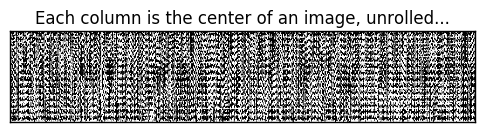

In [20]:
# Cut out the center part of the image (Actual digit)
center_img = [img.reshape(28, 28)[8:22, 8:22].ravel() for img in  data.train.images[:1000]]

# Plot 
plt.figure()
plt.imshow(np.logical_not(center_img).T, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("Each column is the center of an image, unrolled...")

In [ ]:
# We start by building the model 
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))

y_true = tf.placeholder(tf.float32, [None, 10])
y_pred = tf.matmul(x, W)

In [ ]:
cross_entropy = \
    tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [ ]:
gd_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [ ]:
correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

In [ ]:
NUM_STEPS = 1000
MINIBATCH_SIZE = 100

with tf.Session() as sess:

    # Train
    sess.run(tf.global_variables_initializer())
    for _ in range(NUM_STEPS):
        batch_xs, batch_ys = data.train.next_batch(MINIBATCH_SIZE)
        sess.run(gd_step, feed_dict={x: batch_xs, y_true: batch_ys})

    # Test
    is_correct, acc = sess.run([correct_mask, accuracy], 
                               feed_dict={x: data.test.images, y_true: data.test.labels})

print "Accuracy: {:.4}%".format(acc*100)


# Which images did we get wrong?
The softmax-regression model gets over 8% of the test-set wrong! Later on when we use CNNs things will look much better... (State of the art systems acheive virtually perfect accuracy on this dataset).

But first let's take a look at which digit images we got right, and which we got wrong. Recall softmax-regression doesn't model the relationship between pixels, but rather considers them independently. Does this explain some of the errors we see?   

In [ ]:
is_correct

In [ ]:
correct_ix = np.where(is_correct)[0]
correct_img = data.test.images[np.random.choice(correct_ix)].reshape(28, 28)
plt.figure()
plt.imshow(correct_img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("We got this one right!")

In [ ]:
incorrect_ix = np.where(np.logical_not(is_correct))[0]
incorrect_img = data.test.images[np.random.choice(incorrect_ix)].reshape(28, 28)
plt.figure()
plt.imshow(incorrect_img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("But didn't do so well with this one...")

# Exercises
## 1. Confusion matrix 
A confusion matrix is a table where the [i ,j]-th element details the number of examples from class i which were classified as class j. The diagonal reprsents correct classification, and other elements represent the types of error that occur. 

### 1.1 Construct and print the confusion matrix for the softmax regression model and the MNIST dataset. 

### 1.2 Which digits are most confused with which? Is it symmetric? Does this make sense?


useful hints:
1. 
~~~python 
from sklearn.metrics import confusion_matrix 
~~~
2. 
~~~python
sess.run([correct_mask, accuracy, y_pred ]... 
~~~

## 2. Softmax regression with a bias term
It is common to add a scalar "bias" term to the regression formulation:

$ evidence(i) = \langle x, w^i \rangle + b_i $ 

### 2.1 Add a bias term to the TF model

### 2.2 Did the results chnage? Explain...

---

Solution available at: < GitHub link goes here...> 